<a href="https://colab.research.google.com/github/yoo-soo/Anomaly_Detection/blob/main/%5B2022_1127%5D_%EB%84%A4%ED%8A%B8%EC%9B%8C%ED%81%AC_%EC%9D%B4%EC%83%81%ED%83%90%EC%A7%80_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **PCAP을 활용한 침입 탐지 및 이상탐지 예제 실습**

In [ ]:
!pip install dpkt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 패키지 임포트

In [ ]:
import dpkt
import socket

### PCAP 파일 업로드 후 읽기

In [ ]:
# 파일 업로드
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))


Saving 2-2.icmp_flooding.pcap to 2-2.icmp_flooding.pcap
User uploaded file "2-2.icmp_flooding.pcap" with length 12705036 bytes


FileNotFoundError: ignored

In [ ]:
from dpkt.utils import compat_ord
# 파일 읽기
file = '2-2.icmp_flooding.pcap'
f = open(file, 'rb')
pcap_file = dpkt.pcap.Reader(f)

### 패킷 확인

In [ ]:
# inet_to_str 
def inet_to_str(inet):
  try:
    return socket.inet_ntop(socket.AF_INET, inet)
  except ValueError:
    return socket.inet_ntop(socket.AF_INET6, inet)

# mac_addr
def mac_addr(address):
  return ':'.join('%02x' % compat_ord(mac) for mac in address)

cnt = 1
for timestamp, buf in pcap_file:
  if cnt == 5: break
  print("timestamp:{}, length:{}, buf:{}".format(timestamp, len(buf), buf))

  ## buf 데이터를 dkpt 라이브러리 eth 클래스에 입력값으로 넣음
  eth = dpkt.ethernet.Ethernet(buf)

  ## MAC Address 확인
  print(eth.dst, eth.src)
  # print("MAC Address - dst:{}, MAC Address - src:{}".format(mac_addr(eth.dst), mac_addr(eth.src)))

  ## eth, eth.data, eth.data.data  타입 확인
  print(type(eth), type(eth.data), type(eth.data.data))

  ## eth.data의 dst, src 확인
  print(eth.data.dst, eth.data.src)
  # print("IP Address - dst:{}, IP Address - src:{}".format(inet_to_str(eth.data.src), inet_to_str(eth.data.dst)))
  
  print(type(eth),eth.pack)
  print(type(eth.data),eth.data.pack)
  print(type(eth.data.data),eth.data.data.pack)
  cnt +=1

timestamp:1474943271.325528, length:1442, buf:b'\x00\xa0\xd1\xe7\xae:\x00\xa0\xd1\xe6\xb0\xd4\x08\x00E\x00\x05\x94I\xfd\x00\x00@\x01\xddQ"\xb9\x06\x87\xc0\xa8d2\x08\x00>\xd4.~\xf9\x1bXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX



### Feature - BPS 구하기

In [ ]:
# 파일 다시 읽기
file = '2-2.icmp_flooding.pcap'
f = open(file, 'rb')
pcap_file = dpkt.pcap.Reader(f)

## 변수
cnt = 1         ## 패킷 카운트
start_ts = 0.0  ## 시작 시간 
TW_size = 1.0   ## 타임윈도우 크기
SW_size = 1.0   ## 슬라이딩 크기
Bytes = 0       ## 누적 바이트 값


for timestamp, buf in pcap_file:
  if cnt == 1:
    start_ts = timestamp

  ## 시간 체크
  if timestamp <= start_ts + TW_size:
    Bytes += len(buf)
  elif timestamp > start_ts + TW_size:
    print(Bytes/1024.0, timestamp, start_ts + TW_size)

    Bytes = len(buf)      ## 현재 패킷의 bytes를 저장
    start_ts += TW_size   ## start timestamp를 새로운 기준 시간으로 변경
  cnt += 1

1339.201171875 1474943272.326194 1474943272.325528
1342.017578125 1474943273.326108 1474943273.325528
1342.017578125 1474943274.325644 1474943274.325528
1343.42578125 1474943275.325643 1474943275.325528
1343.42578125 1474943276.325985 1474943276.325528
1343.42578125 1474943277.326471 1474943277.325528
1343.42578125 1474943278.325861 1474943278.325528
1342.017578125 1474943279.325936 1474943279.325528
1343.42578125 1474943280.326468 1474943280.325528


### Feature - PPS구하기


In [ ]:
# 파일 다시 읽기
file = '2-2.icmp_flooding.pcap'
f = open(file, 'rb')
pcap_file = dpkt.pcap.Reader(f)

## 변수
cnt = 1         ## 패킷 카운트
start_ts = 0.0  ## 시작 시간 
TW_size = 1.0   ## 타임윈도우 크기
SW_size = 1.0   ## 슬라이딩 크기
c_pkt = 1       ## 누적 바이트 값


for timestamp, buf in pcap_file:
  if cnt == 1:
    start_ts = timestamp

  ## 시간 체크
  if timestamp <= start_ts + TW_size:
    c_pkt += 1
  elif timestamp > start_ts + TW_size:
    print(c_pkt, timestamp, start_ts + TW_size)

    c_pkt = 1             ## 패킷수 1을 저장
    start_ts += TW_size   ## start timestamp를 새로운 기준 시간으로 변경
  cnt += 1

951 1474943272.326194 1474943272.325528
953 1474943273.326108 1474943273.325528
953 1474943274.325644 1474943274.325528
954 1474943275.325643 1474943275.325528
954 1474943276.325985 1474943276.325528
954 1474943277.326471 1474943277.325528
954 1474943278.325861 1474943278.325528
953 1474943279.325936 1474943279.325528
954 1474943280.326468 1474943280.325528


### KDD 데이터셋 샘플링 파일 Colab 머신에 업로드



In [ ]:
# 파일 업로드
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving kddcup_dataset.csv to kddcup_dataset.csv
User uploaded file "kddcup_dataset.csv" with length 4280135 bytes


In [ ]:
!pip install collection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for collection: filename=collection-0.1.6-py3-none-any.whl size=5116 sha256=6151a92c60204a8bb37601d997194f6a7c65373beab4819cb517b4556f97bfda
  Stored in directory: /root/.cache/pip/wheels/45/ed/3c/29a1c0600bb908a2e7421dc3a3775cbaed434a71b4ed93a439
Successfully built collection


### 트래픽 유형 조사

In [ ]:
import pandas as pd
from collections import Counter

kdd_df = pd.read_csv("kddcup_dataset.csv", index_col = None)

y = kdd_df["label"].values
Counter(y).most_common()

[('normal', 39247),
 ('back', 1098),
 ('apache2', 794),
 ('neptune', 93),
 ('phf', 2),
 ('portsweep', 2),
 ('saint', 1)]

### 대상 목표 레이블의 이진화 수행

In [ ]:
def label_abnormal(text):
  ### 대상 목표 레이블을 정상(normal) 또는 이상(abnormal)로 이진화 수행
  if text == "normal":
    return 0
  else:
    return 1

kdd_df["label"] = kdd_df["label"].apply(label_abnormal)

### 정상 관측 대비 이상 비율 계산

In [ ]:
y = kdd_df["label"].values
# y
counts = Counter(y).most_common()
# counts

# counts[1][1] => normal인 label을 제외한 label을 가지고 있는 레코드 수
# counts[0][1] => normal인 label을 가지고 있는 레코드 수

abnormal_rate = counts[1][1] / (counts[0][1] + counts[1][1])
# abnormal_rate

0.04825763270848995

### 범주형 특성 -> 수치형 변환

In [ ]:
from sklearn.preprocessing import LabelEncoder

encodings_dict = dict()

for column_name in kdd_df.columns:
  if kdd_df[column_name].dtype == "object":
    encodings_dict[column_name] = LabelEncoder()
    kdd_df[column_name] = encodings_dict[column_name].fit_transform(kdd_df[column_name])

### 정상 관측 개체 및 이상 관측 개체 분할

In [ ]:
kdd_df_normal = kdd_df[kdd_df["label"] == 0]
kdd_df_abnormal = kdd_df[kdd_df["label"] == 1]

y_normal = kdd_df_normal.pop("label").values
x_normal = kdd_df_normal.values

y_abnormal = kdd_df_abnormal.pop("label").values
x_abnormal = kdd_df_abnormal.values

### Train / Test 데이터 분할

In [ ]:
from sklearn.model_selection import train_test_split
x_normal_train, x_normal_test, y_normal_train, y_normal_test = \
train_test_split(x_normal, y_normal, test_size=0.3, random_state=11)

x_abnormal_train, x_abnormal_test, y_abnormal_train, y_abnormal_test = \
train_test_split(x_abnormal, y_abnormal, test_size=0.3, random_state=11)

import numpy as np
x_train = np.concatenate((x_normal_train, x_abnormal_train))
y_train = np.concatenate((y_normal_train, y_abnormal_train))
x_test = np.concatenate((x_normal_test, x_abnormal_test))
y_test = np.concatenate((y_normal_test, y_abnormal_test))

### IsolationForest 분류기 알고리즘 적용

In [ ]:
from sklearn.ensemble import IsolationForest

IF = IsolationForest(contamination = abnormal_rate)
IF.fit(x_train, y_train)

IsolationForest(contamination=0.04825763270848995)

### **결과**

In [ ]:
decisionScores_train_normal = IF.decision_function(x_normal_train)
decisionScores_train_abnormal = IF.decision_function(x_abnormal_train)

### 정상 데이터셋 점수 그래프

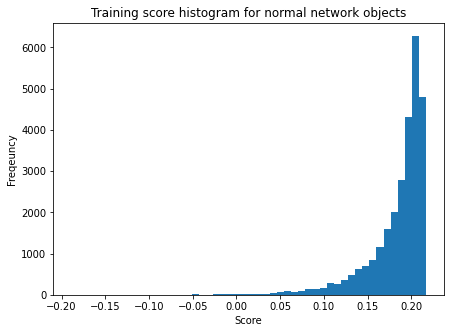

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.figure(figsize=(7,5))
plt.title("Training score histogram for normal network objects")
plt.xlabel("Score")
plt.ylabel("Freqeuncy")
_ = plt.hist(decisionScores_train_normal, bins=50)

### 이상 데이터셋 점수 그래프

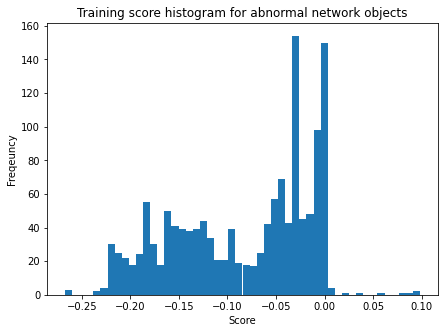

In [ ]:
%matplotlib inline
plt.figure(figsize=(7,5))
plt.title("Training score histogram for abnormal network objects")
plt.xlabel("Score")
plt.ylabel("Freqeuncy")
_ = plt.hist(decisionScores_train_abnormal, bins=50)

### 정상 및 이상 관측치 구분을 위한 임계값 선택

In [ ]:
Cutoff = 0

normal_in_test = Counter(y_test)[0]
abnormal_in_test = Counter(y_test)[1]
print("차단값을 적용 안했을 때 테스트 세트에서의 정상 패킷 수 :{}, 비정상 패킷 수{}".format(normal_in_test, abnormal_in_test))

cutoff_normal_in_test = Counter(y_test[Cutoff > IF.decision_function(x_test)])[0]
cutoff_abnormal_in_test = Counter(y_test[Cutoff > IF.decision_function(x_test)])[1]
print("차단값을 적용 했을 때 테스트 세트에서의 정상 패킷 수 :{}, 비정상 패킷 수{}".format(cutoff_normal_in_test, cutoff_abnormal_in_test))

차단값을 적용 안했을 때 테스트 세트에서의 정상 패킷 수 :11775, 비정상 패킷 수597
차단값을 적용 했을 때 테스트 세트에서의 정상 패킷 수 :29, 비정상 패킷 수557
